In [10]:
# %tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import numpy as np
import pandas as pd
from keras.layers import Input, Dense, Activation, Flatten, Conv2D, Lambda, MaxPooling2D, Dropout
from keras.utils import print_summary
from keras import models
from keras import layers
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import inception_v3
from keras_preprocessing.image import ImageDataGenerator
from scipy import pi


2.1.0


In [14]:
trainDF = pd.read_csv('/home/jupyter/Project/train.txt', sep=" ", header=None)
trainDF.columns = ['Images', 'SteeringAngle'] 
trainDF['SteeringAngle'] = trainDF['SteeringAngle'] * (pi / 180)

testDF = pd.read_csv('/home/jupyter/Project/test.txt', sep=" ", header=None)
testDF.columns = ['Images', 'SteeringAngle'] 

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator=datagen.flow_from_dataframe(
dataframe=trainDF,
directory="/home/jupyter/Project/train/",
x_col="Images",
y_col="SteeringAngle",
subset="training",
batch_size=100,
seed=42,
shuffle=False,
class_mode="raw",
target_size=(200,75))

validation_generator = datagen.flow_from_dataframe(
dataframe=trainDF,
directory="/home/jupyter/Project/train/",
x_col="Images",
y_col="SteeringAngle",
subset="validation",
batch_size=100,
seed=42,
shuffle=False,
class_mode="raw",
target_size=(200,75))


Found 27342 validated image filenames.
Found 9113 validated image filenames.


In [15]:
from keras.regularizers import l2

def Inception_FE(width, height, depth):

    conv_base = inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(height, width, depth))

    model = models.Sequential()
    model.add(conv_base)
    conv_base.trainable = False
    model.add(layers.Flatten())

    model.add(Dense(1164, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='relu'))    
    model.add(Dense(1, activation='linear'))

    return model


In [17]:
NUM_EPOCHS = 30

model = Inception_FE(width=75, height=200, depth=3)
print (model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss="mse")

filepath = "/home/jupyter/Project/Inception/Inception_FE_Chkpt/Inception_FE_weights.{epoch:02d}-{val_loss:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

history = model.fit(
                train_generator,
                steps_per_epoch=329,
                epochs=NUM_EPOCHS,
                validation_data=validation_generator,
                validation_steps=37,
                callbacks=[checkpoint])


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 4, 1, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1164)              9536652   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1164)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               116500    
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)               

/home/jupyter/.local/lib/python3.5/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


329/329 [==============================] - 114s 346ms/step - loss: 0.2092 - val_loss: 0.0026

Epoch 00002: val_loss did not improve from 0.00249
Epoch 3/30
329/329 [==============================] - 114s 346ms/step - loss: 0.2204 - val_loss: 5.3889e-05

Epoch 00003: val_loss improved from 0.00249 to 0.00005, saving model to /home/jupyter/Project/Inception/Inception_FE_Chkpt/Inception_FE_weights.03-0.00.h5
Epoch 4/30
329/329 [==============================] - 114s 346ms/step - loss: 0.1976 - val_loss: 0.0014

Epoch 00004: val_loss did not improve from 0.00005
Epoch 5/30
329/329 [==============================] - 114s 346ms/step - loss: 0.1942 - val_loss: 0.0022

Epoch 00005: val_loss did not improve from 0.00005
Epoch 6/30
329/329 [==============================] - 114s 347ms/step - loss: 0.1967 - val_loss: 0.0019

Epoch 00006: val_loss did not improve from 0.00005
Epoch 7/30
329/329 [==============================] - 115s 350ms/step - loss: 0.2183 - val_loss: 0.0018

Epoch 00007: val_l

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


avg_train_loss: 0.2000716601479321
avg_val_loss: 0.7547526066777815
difference: 0.5546809465298495


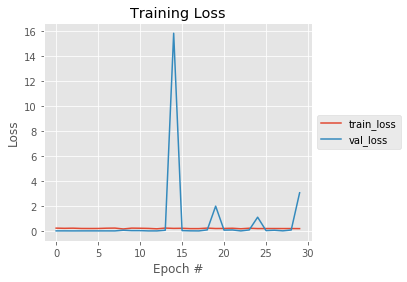

In [19]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, NUM_EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, NUM_EPOCHS), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

avg_train_loss = sum(history.history["loss"])/NUM_EPOCHS
avg_val_loss = sum(history.history["val_loss"])/NUM_EPOCHS

print("avg_train_loss: " + str(avg_train_loss))
print("avg_val_loss: " + str(avg_val_loss))
print("difference: " + str(abs(avg_train_loss - avg_val_loss)))

In [23]:
from keras.models import load_model

test_generator=test_datagen.flow_from_dataframe(
dataframe=testDF,
directory="/home/jupyter/Project/test/",
x_col="Images",
# y_col="SteeringAngle",
y_col=None,    
batch_size=100,
seed=42,
shuffle=False,
class_mode=None,
target_size=(200, 75))

filepath = "/home/jupyter/Project/Inception/Inception_FE_Chkpt/Inception_FE_weights.03-0.00.h5"

model.load_weights(filepath)


predictions = model.predict(test_generator)
print('Predictions: ', predictions.shape)

Found 8951 validated image filenames.
Predictions:  (8951, 1)


In [24]:
import pandas as pd

Images = testDF['Images']
preds = predictions
actual = testDF['SteeringAngle']

df_preds = pd.DataFrame(Images)
df_preds['Actual Steering Angle'] = (actual * (pi / 180))
df_preds['Predicted Steering Angle'] = preds
df_preds.rename(columns = {0:'Images'}, inplace = True) 

df_preds['MAE'] = 0

for i in range(len(df_preds)):
  df_preds.iloc[i, -1] = abs(df_preds.iloc[i, 1] - df_preds.iloc[i, 2])

mae_sum = 0
for i in range(len(df_preds)):
    mae_sum += df_preds.iloc[i, -1]
    
print("mae_sum: " + str(mae_sum))    
MAE = mae_sum / len(df_preds)
print("len(df_preds): " + str(len(df_preds)))
print("MAE: " + str(MAE))

mae_sum: 1965.2926250380465
len(df_preds): 8951
MAE: 0.2195612361789796


In [25]:
df_preds[8900:]

,Images,Actual Steering Angle,Predicted Steering Angle,MAE
8900,45355.jpg,0.103847,0.001777,0.102070
8901,45356.jpg,0.100356,-0.011318,0.111675
8902,45357.jpg,0.093201,0.005457,0.087744
8903,45358.jpg,0.089710,0.003404,0.086306
8904,45359.jpg,0.086219,0.009373,0.076846
8905,45360.jpg,0.080983,0.011377,0.069607
8906,45361.jpg,0.074002,0.004684,0.069318
8907,45362.jpg,0.074002,0.008473,0.065529
8908,45363.jpg,0.066846,0.007765,0.059081
8909,45364.jpg,0.063355,0.007095,0.056261
